In [185]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import re
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

data_url = 'https://twd-sagemaker.s3.amazonaws.com/movies.json'

# Load Data

In [175]:
# load json file into pandas dataframe
df = pd.read_json(data_url)

# Pre-Processing and Creating a Training, Validation, and Testing Datasets
The model will be built using a training dataset, a set of examples used to fit the parameters of the model. Our model will use features extracted from the movies' plots as input variables, and predict the genre of the movie. The records included int the training dataset must therefore all have a plot synopsis and a genre label. Records withut both are removed. Standard practice is to use 70% of the full dataset for training purposes, while reserving 20% for validating and 10% for testing. A random sample of 70% of the data is therefore selected for training.

In [218]:
# Remove rows without a genre or plot synopsis
_df = df.loc[(df['Genre'] != 'N/A') & (df['Plot'] != 'N/A')].copy()

# Funciton to break the genre string into a list of genres
def make_genre_list(g):
    return([x.strip() for x in g.split(',')])

# Function to clean the text of the plot summaries
def clean_text(text):
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    return(text)

# Break genres into a list
_df['Genre'] = _df['Genre'].apply(make_genre_list)
# Clean the plot summary text
_df['clean_plot'] = _df['Plot'].apply(lambda x: clean_text(x))

# Split data randomly into training and testing datasets
train, validate, test = np.split(_df.sample(frac=1), [int(.7*len(df)), int(.9*len(df))])
train

,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,...,Writer,Year,imdbID,imdbRating,imdbVotes,totalSeasons,Episode,Season,seriesID,clean_plot
14453,"Adam West, Burt Ward, Julie Newmar, Jeff Bergman",2 nominations.,N/A,USA,01 Nov 2016,Rick Morales,"[Animation, Action, Adventure, Comedy, Crime, ...","English, German",N/A,Batman and Robin of the 1960s live action seri...,...,"Michael Jelenic (screenplay by), James Tucker ...",2016,tt5973626,6.9,"4,038",NaN,NaN,NaN,NaN,batman and robin of the s live action series a...
7682,"Sam Huntington, Meaghan Rath, Darren Curtis, R...",N/A,N/A,Canada,23 Mar 2015,Pat Kiely,"[Comedy, Drama]",English,N/A,A married couple's romantic weekend is turned ...,...,Pat Kiely,2013,tt2597718,5.6,"1,769",NaN,NaN,NaN,NaN,a married couple s romantic weekend is turned ...
3243,"François Sagat, Omar Ben Sellem, Chiara Mastro...",1 nomination.,N/A,France,22 Jan 2015,Christophe Honoré,[Drama],"French, English",N/A,"Between Gennevilliers and New York, Omar and E...",...,Christophe Honoré (screenwriter),2010,tt1701995,5.1,838,NaN,NaN,NaN,NaN,between gennevilliers and new york omar and em...
6425,"Debbie Allen, Kaye Ballard, Harry Belafonte, D...",Nominated for 2 Primetime Emmys. Another 2 win...,N/A,USA,20 May 2014,Whoopi Goldberg,"[Documentary, Comedy]",English,N/A,A look at the work and influence of African-Am...,...,N/A,2013,tt2319863,8.0,227,NaN,NaN,NaN,NaN,a look at the work and influence of african am...
16397,Bert Kreischer,N/A,N/A,N/A,24 Aug 2018,Todd Biermann,"[Documentary, Comedy]",N/A,N/A,Bert regales the audience at the Trocadero The...,...,Bert Kreischer,2018,tt8786466,7.3,976,NaN,NaN,NaN,NaN,bert regales the audience at the trocadero the...
2,"Charlie Sheen, Hilary Duff, Eva Longoria, Wayn...",N/A,N/A,USA,N/A,Lawrence Kasanoff,"[Animation, Action, Comedy, Family, Fantasy, M...",English,N/A,The evil Brand X joins a supermarket that beco...,...,"Lawrence Kasanoff (story), Joshua Wexler (stor...",2012,tt0249516,1.9,"8,189",NaN,NaN,NaN,NaN,the evil brand x joins a supermarket that beco...
4925,"Lori Alan, Carlos Alazraqui, Tim Allen, Bob Be...",N/A,N/A,USA,N/A,"Angus MacLane, Dylan Brown","[Animation, Short, Comedy, Family, Fantasy]",English,N/A,A fast food restaurant mini variant of Buzz fo...,...,"Angus MacLane, Angus MacLane (story), John Las...",2011,tt2033372,7.1,"4,678",NaN,NaN,NaN,NaN,a fast food restaurant mini variant of buzz fo...
2236,"Michael Herbig, Jürgen Vogel, Thekla Reuten, V...",4 wins & 7 nominations.,N/A,"Germany, Liechtenstein, France",N/A,Leander Haußmann,[Comedy],"German, Russian, English",N/A,"In 1938 Hans Zeisig, an apolitical comedian, i...",...,"Leander Haußmann (screenplay), Uwe Timm (based...",2011,tt1529559,6.0,"1,090",NaN,NaN,NaN,NaN,in hans zeisig an apolitical comedian imperson...
3863,"Naoto Takenaka, Yuriko Yoshitaka, Gaku Hamada,...",1 nomination.,N/A,Japan,N/A,Shinobu Yaguchi,"[Comedy, Drama]",Japanese,N/A,Three employees of the Kimura Electrical Compa...,...,Shinobu Yaguchi (screenplay),2012,tt1805492,6.9,479,NaN,NaN,NaN,NaN,three employees of the kimura electrical compa...
4890,"Guillaume Canet, Marina Hands, Daniel Auteuil,...",4 nominations.,N/A,"France, Canada",N/A,Christian Duguay,"[Biography, Drama, Sport]","French, English",N/A,A horse with amazing courage and a big heart.,...,"Guillaume Canet (scenario and adaptation), Kar...",2013,tt2018079,6.7,"1,358",NaN,NaN,NaN,NaN,a horse with amazing courage and a big heart


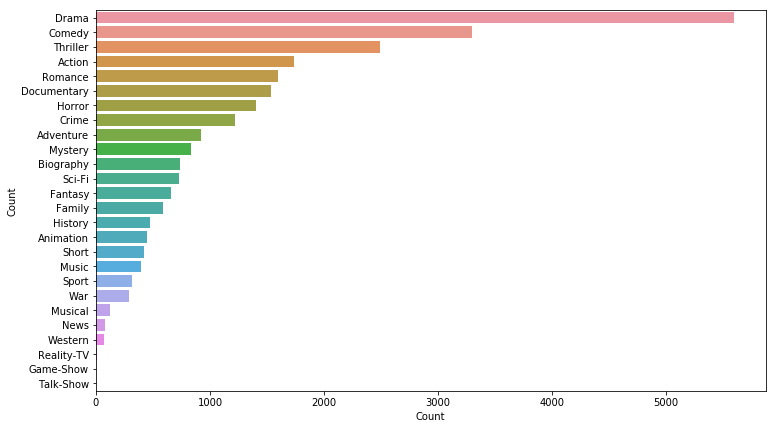

In [177]:
# Inspect the genres
genres = [y for x in train['Genre'] for y in x]
all_genres = nltk.FreqDist(genres) 
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,7)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

# Feature Extraction

In [192]:
# Create target matrix
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(_df['Genre'])
train_y = multilabel_binarizer.transform(train['Genre'])
test_y = multilabel_binarizer.transform(test['Genre'])

# Create predictors matrix
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=1000, stop_words='english')
train_x = tfidf_vectorizer.fit_transform(train['clean_plot'])
test_x = tfidf_vectorizer.fit_transform(test['clean_plot'])

In [198]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(train_x, train_y)

# predict on test
pred_y = clf.predict(test_x)
f1_score(test_y, pred_y, average="micro")


/usr/local/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))


0.21499825601674227

In [211]:
# predict probabilities
y_pred_prob = clf.predict_proba(test_x)

t = 0.2 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [212]:
# evaluate performance
f1_score(test_y, y_pred_new, average="micro")

0.38380610972568574

In [227]:
def infer_tags(q):
    q = clean_text(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)
infer_tags(test['clean_plot'][14083]), test['Genre'][14083]

([('Drama',)], ['Drama', 'Mystery', 'Thriller'])

In [225]:
test['clean_plot']

6603     to many don mccullin is the greatest living wa...
14083    when four estranged brothers return home to sa...
3661     a group of college students ventured into the ...
4333     alberto forms an unusual friendship with luly ...
14008    two young friends find a magic book that bring...
                               ...                        
4059     charlie rankin recently released from prison s...
12596    a bank robbery goes terribly wrong when one of...
4132     a seedy bar owner hires a mysterious croatian ...
6430     a former olympic champion wants to compete in ...
3734     the legendary roberto duran and his equally le...
Name: clean_plot, Length: 1112, dtype: object

In [220]:
kf

sklearn.cross_validation.KFold(n=25, n_folds=5, shuffle=False, random_state=None)